<a href="https://colab.research.google.com/github/jaramillooo/Proyecto_series_no_lineales/blob/main/proyecto12ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

___
<img style="float: left; margin: 30px 15px 15px 15px;" src="https://d33wubrfki0l68.cloudfront.net/4ec62c1c925a380c912ddad740d18554c6822a11/fabe4/img/sponsors/iteso-university.png" width="300" height="500" /> 
    
    
# Modelado de pronóstico de series de tiempo. 

**Nombres:** 
- Kaleb Azael Avila Padilla
- Axel Cabrera Jaramillo
- Manuel Alejandro Murguía Orantes

**Expediente**:
- 724405
- 730793
- 739360

**Fecha:** 09 de mayo del 2024.

**Profesor:** Oscar David Jaramillo Zuluaga.
    
**Link Github**: https://github.com/jaramillooo/proyecto_modulo1

## Proyecto Final

### Proyecto Final - Guía.
> Se especifican los componentes básicos que deberá tener cada proyecto. El proyecto debe ser un problema que utilice datos reales, ya sea de una empresa física real o de alguna página de internet que proporcione bases de datos confiables. Con la información obtenida, se pretende utilizar todas las herramientas vistas durante el curso para la correcta modelación y simulación del cierto problema con ciertas variables de interés.

> De la base seleccionada debe de poder aplicarse cada uno de las tres secciones del curso. 
> 1. Predicción de series de tiempo lineal (SARIMAX).  
> 2. Predicción de series de tiempo no lineal (MLP, CNN, LSTM, etc).
> 3. Clasificación de series de tiempo. Si la base de datos no tiene información suficiente para poder realizar clasificación, se puede utilizar otra base de datos diferente para aplicar las técnicas vistas para clasificar series de tiempo

___
## 1. Entregable.
Los trabajos deben tener los siguientes componentes básicos.

### 1.1 Título del trabajo.
> Debe describir el trabajo.

### 1.2 Objetivos.
> - Se refieren a los propósitos por los cuales se hace el trabajo.
> - Deben ser **concretos, evaluables y verificables.**
> - Deben ser escritos en infinitivo.
> #### 1.1 Objetivo general.
>  - Fin último de estudio. Se formula atendiendo el propósito global del trabajo. No presenta detalles.
>  - Se orienta a la totalidad del trabajo. Tiene que ver con el título del trabajo.
> #### 1.2 Objetivos específicos
>  - De forma detallada describen cada una de los componentes del trabajo.
>  - En conjunto garantizan la consecución del objetivo general.

Referencia:
- https://es.slideshare.net/rosbur/metodologia-objetivos-generales-y-especficos

### 1.3 Definición del problema.
> Se debe describir en una cuartilla máximo cuál es el escenario de negocio que se va a modelar, identificar cuáles son los supuestos que defines en el negocio y cuáles son los "nodos" o "escenarios" que identificas necesarios simular y porqué. Debes elaborar un diagrama de inicio a fin, identificando los "nodos" o "escenarios" a simular.

### 1.4 Nodos y variables que se decidieron simular y porqué
> En este apartado el objetivo es identificar los problemas que se van a abordar, para examinar la factibilidad y viabilidad de la simulación de los nodos escogidos. Posteriormente se debe de argumentar del porqué de los nodos escogidos.

### 1.5 Obtención de bases de datos
> El tercer paso del proyecto es indicar de dónde se obtendrán las bases de datos, que indican como se han comportado las variables que identificaste en tu proceso de negocio que vas a simular. En esta investigación debes haber encontrado información propia de la empresa, organización o institución que vas a simular y otra parte de la información debe provenir de investigación que realices en fuentes de información públicas o privadas como las que tiene SECOBI, ahí normalmente y dependiendo del problema elegido, se investigan variables económicas, como tasas de interés, inflación, tipo de cambio, etc., de varios años, por poner un ejemplo.

### 1.6 Visualización de resultados de simulación.
> Para cada uno de los temas del curso, realizar la estimación y predicción de errores de los algoritmos propuestos. Al final luego de obtener los resultados de cada tema realizar una comparación de los resultados lineales y no lineales y concluir los distintos resultados.

### 1.7 Conclusiones.
> Mucho cuidado, las conclusiones no son cualquier cosa. Se debe concluir respecto a los objetivos planteados de acuerdo a los resultados obtenidos.

### 1.8 Referencias.
> Citar (en formato APA) la bibliografía utilizada.

# Daily Demand Forecasting Orders

### [Link del Dataset](https://archive.ics.uci.edu/dataset/409/daily+demand+forecasting+orders).

Variables:
- Week of the month	Feature	Integer	(first, second, third, fourth or fifth week) -> {1.0, 2.0, 3.0, 4.0, 5.0}
- Day of the week (Monday to Friday) -> {2.0, 3.0, 4.0, 5.0, 6.0}
- Non-urgent order
- Urgent order
- Order type A
- Order type B
- Order type C
- Fiscal sector orders
- Orders from the traffic controller sector
- Banking orders (1)
- Banking orders (2)
- Banking orders (3)

Total_orders -> Target


In [1]:
pip install ucimlrepo

Note: you may need to restart the kernel to use updated packages.


In [2]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import timedelta
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import MSTL
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings("ignore")


/Users/kalebavila/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# dataset
daily_demand_forecasting_orders = fetch_ucirepo(id=409)
X = daily_demand_forecasting_orders.data.features
y = daily_demand_forecasting_orders.data.targets
print(daily_demand_forecasting_orders.metadata),print(daily_demand_forecasting_orders.variables)

{'uci_id': 409, 'name': 'Daily Demand Forecasting Orders', 'repository_url': 'https://archive.ics.uci.edu/dataset/409/daily+demand+forecasting+orders', 'data_url': 'https://archive.ics.uci.edu/static/public/409/data.csv', 'abstract': 'The dataset was collected during 60 days, this is a real database of a brazilian logistics company.', 'area': 'Business', 'tasks': ['Regression'], 'characteristics': ['Time-Series'], 'num_instances': 60, 'num_features': 12, 'feature_types': ['Integer'], 'demographics': [], 'target_col': ['Total orders'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2016, 'last_updated': 'Thu Mar 21 2024', 'dataset_doi': '10.24432/C5BC8T', 'creators': ['Ricardo Ferreira', 'Andrea Martiniano', 'Arthur Ferreira', 'Aleister Ferreira', 'Renato Sassi'], 'intro_paper': {'title': 'Study on Daily Demand Forecasting Orders using Artificial Neural Network', 'authors': 'R. P. Ferreira, Andréa Martiniano, Arthur Arruda Leal 

(None, None)

In [4]:
X.head()

,Week of the month,Day of the week,Non-urgent order,Urgent order,Order type A,Order type B,Order type C,Fiscal sector orders,Orders from the traffic controller sector,Banking orders (1),Banking orders (2),Banking orders (3)
0,1,4,316.307,223.270,61.543,175.586,302.448,0.000,65556,44914,188411,14793
1,1,5,128.633,96.042,38.058,56.037,130.580,0.000,40419,21399,89461,7679
2,1,6,43.651,84.375,21.826,25.125,82.461,1.386,11992,3452,21305,14947
3,2,2,171.297,127.667,41.542,113.294,162.284,18.156,49971,33703,69054,18423
4,2,3,90.532,113.526,37.679,56.618,116.220,6.459,48534,19646,16411,20257


In [5]:
X['Datetime'] = pd.to_datetime((X['Week of the month'] - 1) * 7 + X['Day of the week'] - 2, unit='W', origin='2022-01-01')
# adjust the date range to 60 days
X['Datetime'] = X['Datetime'] - pd.Timedelta(days=7)
X.drop(['Week of the month', 'Day of the week'], axis=1, inplace=True)
ds = X.copy()
X.set_index('Datetime', inplace=True)

In [6]:
X.dtypes

Non-urgent order                             float64
Urgent order                                 float64
Order type A                                 float64
Order type B                                 float64
Order type C                                 float64
Fiscal sector orders                         float64
Orders from the traffic controller sector      int64
Banking orders (1)                             int64
Banking orders (2)                             int64
Banking orders (3)                             int64
dtype: object

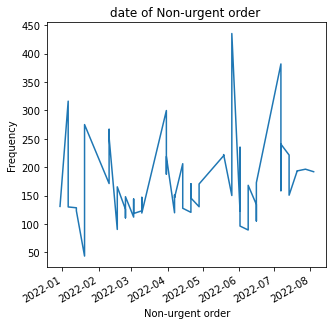

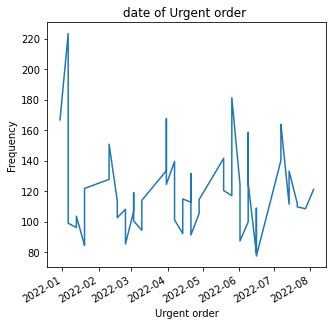

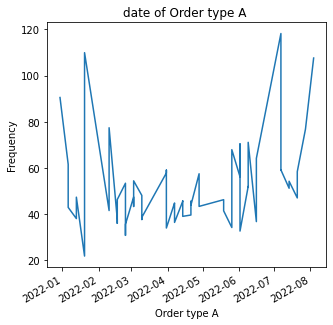

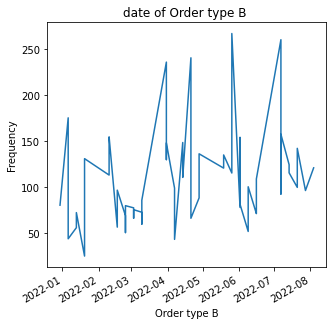

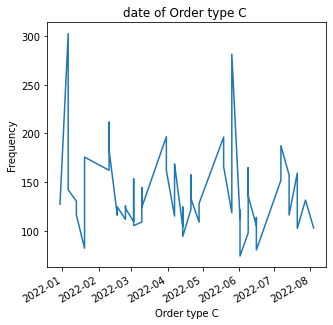

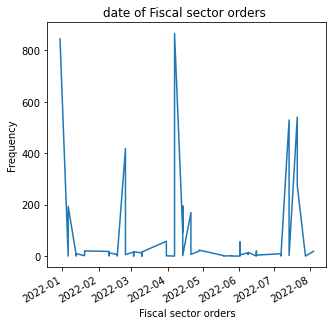

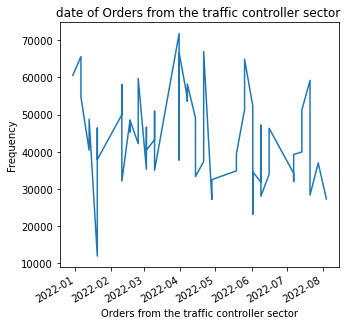

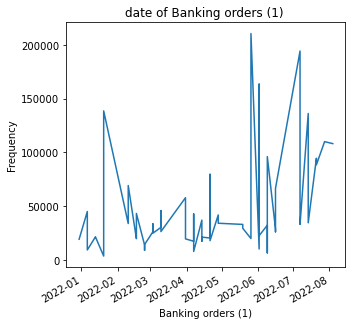

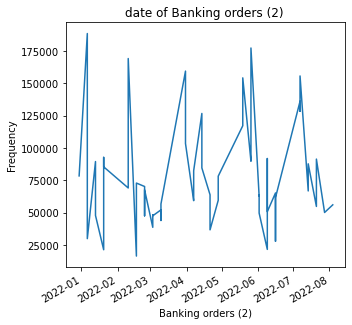

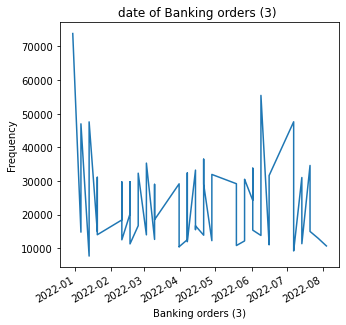

In [7]:
columns_to_plot = [col for col in X.columns if col != 'Datetime']
for col in columns_to_plot:
    plt.figure(figsize=(5, 5))
    X[col].plot()
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.title(f"date of {col} ")
    plt.show()

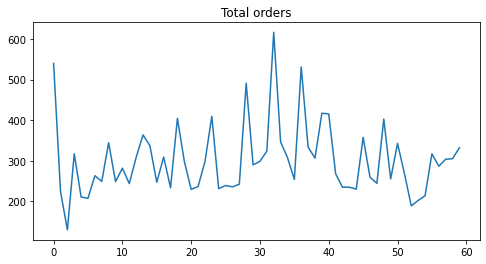

In [8]:
y['Total orders'].plot(kind='line', figsize=(8, 4), title='Total orders')
plt.gca().spines[['top', 'right']].set_visible(True)

In [9]:
_ = pd.DataFrame({
    'Datetime': ds['Datetime'],
    'Total orders': y['Total orders']
})
data = _.set_index('Datetime')
data.head(10)

,Total orders
Datetime,
2022-01-06,539.577
2022-01-13,224.675
2022-01-20,129.412
2022-02-10,317.120
2022-02-17,210.517
2022-02-24,207.364
2022-03-03,263.043
2022-03-10,248.958
2022-03-31,344.291


<AxesSubplot:xlabel='Datetime'>

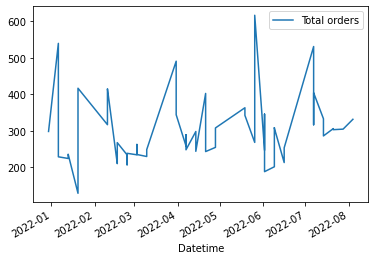

In [10]:
data.plot()

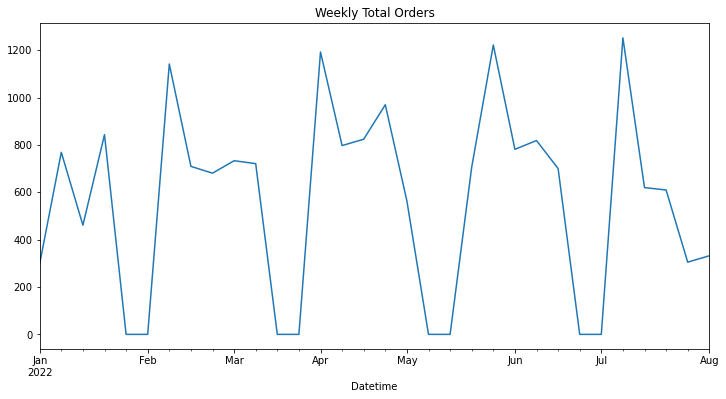

In [29]:
days = data.resample('W')['Total orders'].sum()
days.plot(figsize=(12, 6))
plt.title('Weekly Total Orders')
plt.show()

In [30]:
from scipy.stats import norm
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from io import BytesIO

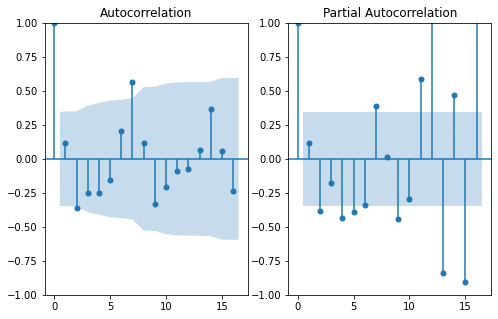

In [31]:
# 1. Graficar ACF y PACF
f = plt.figure(figsize=(8,5))

ax1 = f.add_subplot(121)

plot_acf(days, ax=ax1)

ax2 = f.add_subplot(122)
plot_pacf(days, ax=ax2, method='ols')

plt.show()

In [32]:
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

    if (dftest[1] <= 0.05) & (dftest[4]['5%'] > dftest[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [33]:
adf_test(days)

Results of Dickey-Fuller Test:
Test Statistic                 -1.507899
p-value                         0.529600
#Lags Used                     10.000000
Number of Observations Used    21.000000
Critical Value (1%)            -3.788386
Critical Value (5%)            -3.013098
Critical Value (10%)           -2.646397
dtype: float64
Non-stationary


In [34]:
adf_test(days.diff().dropna())

Results of Dickey-Fuller Test:
Test Statistic                -8.537604e+00
p-value                        9.981672e-14
#Lags Used                     5.000000e+00
Number of Observations Used    2.500000e+01
Critical Value (1%)           -3.723863e+00
Critical Value (5%)           -2.986489e+00
Critical Value (10%)          -2.632800e+00
dtype: float64
Stationary


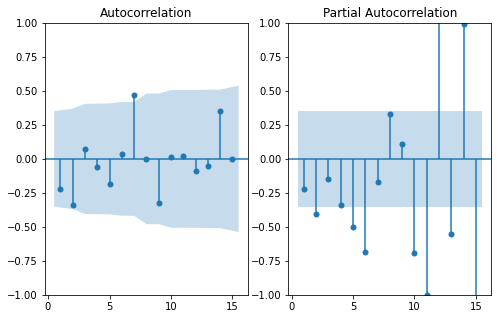

In [35]:

def plot_acf_pacf(data, kwargs=dict()):
    f = plt.figure(figsize=(8,5))

    ax1 = f.add_subplot(121)

    plot_acf(data, zero=False, ax=ax1, **kwargs)

    ax2 = f.add_subplot(122)
    plot_pacf(data, zero=False, ax=ax2, method='ols', **kwargs)

    plt.show()

plot_acf_pacf(days.diff().dropna(), {'lags':15})

In [36]:
from statsmodels.tsa.arima.model import ARIMA
arima_model1 = ARIMA(days, order=(8, 2, 2))
model1 = arima_model1.fit()
print(model1.summary())

                               SARIMAX Results                                
Dep. Variable:           Total orders   No. Observations:                   32
Model:                 ARIMA(8, 2, 2)   Log Likelihood                -215.061
Date:                Tue, 07 May 2024   AIC                            452.123
Time:                        15:12:11   BIC                            467.536
Sample:                    01-02-2022   HQIC                           457.053
                         - 08-07-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9644      1.873     -0.515      0.607      -4.636       2.708
ar.L2         -0.8612      2.577     -0.334      0.738      -5.911       4.189
ar.L3         -0.6888      2.922     -0.236      0.8

<AxesSubplot:xlabel='Datetime'>

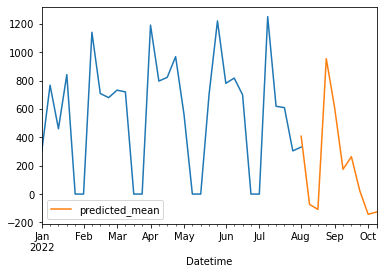

In [37]:
y_h = model1.predict(start=31, end=40, dynamic=False).to_frame()

ax = days.plot()

y_h.plot(ax=ax)

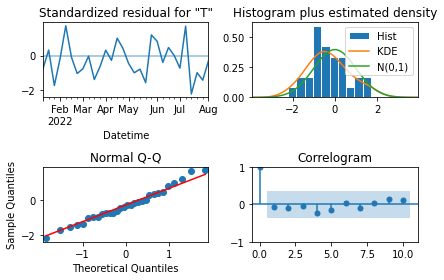

In [38]:
model1.plot_diagnostics()
plt.tight_layout();

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   32
Model:               SARIMAX(2, 0, 0)   Log Likelihood                -234.227
Date:                Tue, 07 May 2024   AIC                            476.454
Time:                        15:12:18   BIC                            482.316
Sample:                    01-02-2022   HQIC                           478.397
                         - 08-07-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    693.2419    133.424      5.196      0.000     431.736     954.747
ar.L1          0.1542      0.192      0.801      0.423      -0.223       0.531
ar.L2         -0.3742      0.185     -2.028      0.0

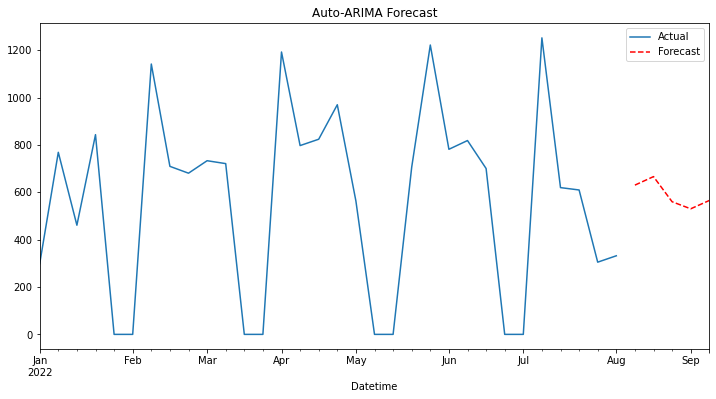

In [39]:
import pandas as pd
import pmdarima as pm
from pmdarima import model_selection

model = pm.auto_arima(days, start_p=3, start_q=0, start_P=1, start_Q=1,
                     max_p=5, max_q=5, max_P=5, max_Q=5, seasonal=True,
                     stepwise=True, suppress_warnings=True, D=7, max_D=10,
                     error_action='ignore')
print(model.summary())
forecast = model.predict(n_periods=5)
days.plot(figsize=(12, 6), label='Actual')
forecast.plot(color='red', linestyle='--', label='Forecast')
plt.legend()
plt.title('Auto-ARIMA Forecast')
plt.show()

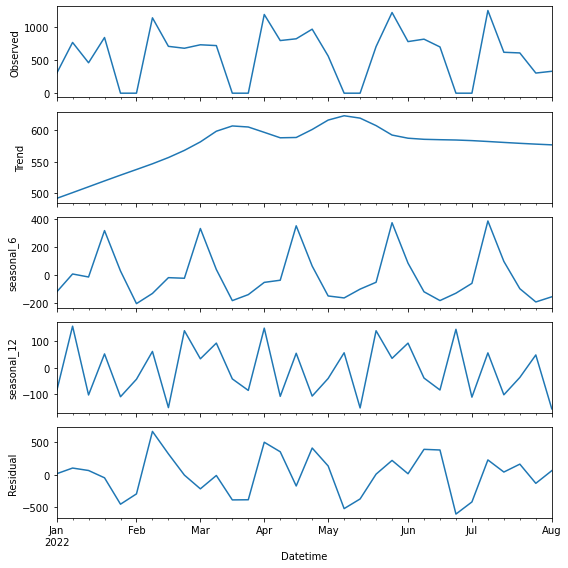

In [40]:
# Función para análisis de estacionalidad
from statsmodels.tsa.seasonal import MSTL
import matplotlib.pyplot as plt

periods_seasonality = (6,12)

stl_kwargs = {"seasonal_deg": 0}
model = MSTL(days, periods=(periods_seasonality), stl_kwargs=stl_kwargs)
res2 = model.fit()

# Gráfica de descomposición
fig, ax = plt.subplots(5, 1, sharex=True, figsize=(8, 8))

res2.observed.plot(ax=ax[0])
ax[0].set_ylabel('Observed')

res2.trend.plot(ax=ax[1])
ax[1].set_ylabel('Trend')

res2.seasonal[f'seasonal_{periods_seasonality[0]}'].plot(ax=ax[2])
ax[2].set_ylabel(f'seasonal_{periods_seasonality[0]}')

res2.seasonal[f'seasonal_{periods_seasonality[1]}'].plot(ax=ax[3])
ax[3].set_ylabel(f'seasonal_{periods_seasonality[1]}')

res2.resid.plot(ax=ax[4])
ax[4].set_ylabel('Residual')

fig.tight_layout()

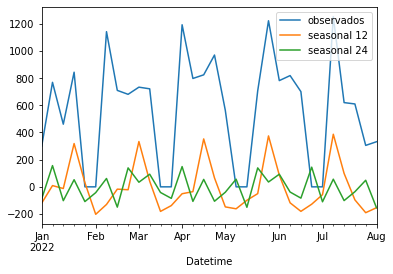

In [41]:
# Graficar datos observados con datos de estacionalidad
ax = res2.observed.plot(label='observados')

res2.seasonal['seasonal_6'].plot(ax=ax, label='seasonal 12')
res2.seasonal['seasonal_12'].plot(ax=ax, label='seasonal 24')

plt.legend()
plt.show()

# Parte 3 Clasificación

Experimental data used for binary classification (room occupancy) from Temperature,Humidity,Light and CO2. Ground-truth occupancy was obtained from time stamped pictures that were taken every minute.

Dataset Characteristics
Multivariate, Time-Series

Associated Tasks
Classification

Feature Type: Real

- Instances
20560

- Features
6

| Variable | Role | Type | Description | Units | Missing Values |
| --- | --- | --- | --- | --- | --- |
| id | ID | Integer |  |  | no |
| date | Feature | Date |  |  | no |
| Temperature | Feature | Integer |  |  | no |
| Humidity | Feature | Continuous |  | % | no |
| Light | Feature | Integer |  | Lux | no |

Variables information:

date time year-month-day hour:minute:second

Temperature, in Celsius

Relative Humidity, %

Light, in Lux

CO2, in ppm

Humidity Ratio, Derived quantity from temperature and relative humidity, in
kgwater-vapor/kg-air

Occupancy, 0 or 1, 0 for not occupied, 1 for occupied status



In [25]:
!pip install ucimlrepo
from ucimlrepo import fetch_ucirepo

# fetch dataset
occupancy_detection = fetch_ucirepo(id=357)

# data (as pandas dataframes)
X = occupancy_detection.data.features
y = occupancy_detection.data.targets

# metadata
print(occupancy_detection.metadata)

# variable information
print(occupancy_detection.variables)


{'uci_id': 357, 'name': 'Occupancy Detection ', 'repository_url': 'https://archive.ics.uci.edu/dataset/357/occupancy+detection', 'data_url': 'https://archive.ics.uci.edu/static/public/357/data.csv', 'abstract': 'Experimental data used for binary classification (room occupancy) from Temperature,Humidity,Light and CO2. Ground-truth occupancy was obtained from time stamped pictures that were taken every minute.', 'area': 'Computer Science', 'tasks': ['Classification'], 'characteristics': ['Multivariate', 'Time-Series'], 'num_instances': 20560, 'num_features': 6, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['Occupancy'], 'index_col': ['id'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2016, 'last_updated': 'Sat Apr 13 2024', 'dataset_doi': '10.24432/C5X01N', 'creators': ['Luis Candanedo'], 'intro_paper': {'title': 'Accurate occupancy detection of an office room from light, temperature, humidity and CO2 measurements using statistic

In [26]:
X.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio
0,2015-02-04 17:51:00,23.18,27.272,426,721.25,0.00479298817650529
1,2015-02-04 17:51:59,23.15,27.2675,429.5,714,0.00478344094931065
2,2015-02-04 17:53:00,23.15,27.245,426,713.5,0.00477946352442199
3,2015-02-04 17:54:00,23.15,27.2,426,708.25,0.00477150882608175
4,2015-02-04 17:55:00,23.1,27.2,426,704.5,0.00475699293331518


In [27]:
numeric_cols = [col for col in X.columns if col!= 'date']
X[numeric_cols] = X[numeric_cols].apply(pd.to_numeric, errors='coerce')
X.dtypes

date              object
Temperature      float64
Humidity         float64
Light            float64
CO2              float64
HumidityRatio    float64
dtype: object

In [28]:
for col in columns_to_plot:
    if X[col].dtype.kind in 'bifc':
        plt.figure(figsize=(5, 5))
        X[col].hist(bins=50)
        plt.xlabel(col)
        plt.ylabel("Frequency")
        plt.title(f"Bar Distribution of {col}")
        plt.show()

KeyError: 'Non-urgent order'

In [ ]:
from sklearn.preprocessing import StandardScaler
X_df = pd.DataFrame(X)
numeric_cols = X_df.select_dtypes(include=['int64','float'])
StandardScaler = StandardScaler()
X_scaled = pd.DataFrame(StandardScaler.fit_transform(numeric_cols), columns=numeric_cols.columns)

In [ ]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()

In [ ]:
X_numeric = X.drop('date', axis=1)
X_scaled = scaler.fit_transform(X_numeric)
X_scaled_df = pd.DataFrame(X_scaled, columns=X_numeric.columns)
X_scaled = pd.concat([X[['date']], X_scaled_df], axis=1)

In [ ]:
X.head()

In [ ]:
for col in X_scaled.columns:
    if col!= 'date':
        plt.figure(figsize=(10, 6))
        X_scaled[col].plot(kind='hist')
        plt.title(col)
        plt.show()

In [ ]:
co2_sqrt = np.sqrt(X_scaled["CO2"])
# plot the transformed data
plt.figure(figsize=(10, 6))
co2_sqrt.plot(kind='hist')
plt.title("CO2")
plt.show()

In [ ]:
co2_sqrt = X_scaled['C02']

In [ ]:
from statsmodels.stats.diagnostic import kstest_normal

log_transformed = np.log(X['CO2'].values + 1)
print(log_transformed)
_, p = kstest_normal(co2_sqrt)  # stats.normaltest
print(f"significance: {p,_}")

In [ ]:
from sklearn.preprocessing import power_transform
co2_sqrt = np.array(co2_sqrt)
vals_bc = power_transform(co2_sqrt.reshape(-1, 1), method='box-cox')

_, p = kstest_normal(vals_bc.squeeze())
print(f"significance: {p:.2f}")